# Automatic Forecasting with TempEst-NEXT

This Notebook automatically generates forecasts out to 17 days for a specified watershed.  It will eventually include three approaches:

1. Pour point forecast: one watershed.
2. Nested forecast: the whole upstream system at kilometer resolution, run as tightly-nested lumped models.
3. Interpolated forecast: the whole upstream system, using kilometer-scale smart interpolation or a reach model between confluences.

For convenience, it is assumed that the downstream point is a USGS gage.  However, NEXT's automatic data retrieval tools can work with coordinates as well, with no gage required.

We will set up the watershed model based on 5 years of daymet data (2018-2022), then run the next 17 days with GFS data (as well as the preceding several days, to get a correct rolling anomaly for the first few days of forecast).

In addition to the dependencies below, using the efficient GFS downloader requires ecCodes, which I installed via eccodes on PyPI, and cfgrib (also PyPI).  This may or may not work on Windows.  The overall forecasting workflow can be modified to use a (slower and less reliable, but cross-platform) retrieval method using `get_gfs` from `NEXT.data` (retrieval provided by the `getgfs` library).  This requires modifying the example (`NEXT.scripts.area_forecast`) source code for `forecast_inputs`.

# Setup and Watershed Identification

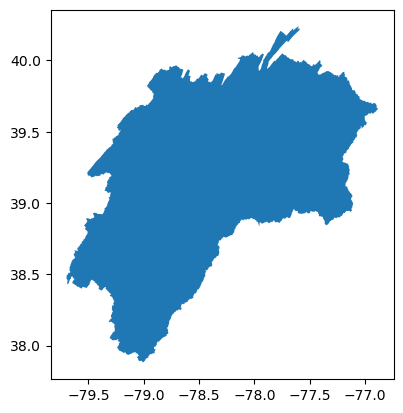

In [26]:
import NEXT
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import datetime
import dataretrieval.nwis as nwis
from pynhd import NLDI
from time import time
from NEXT.scripts.area_forecast import expand_line, expand_lines, run_forecasts, run_forecast, prepare_model, forecast_inputs
import seaborn as sns
# USGS gage as downstream location
# site = "10343500"    # Sagehen Creek nr Truckee, CA.  Small mountain watershed in Eastern Sierra.
site = "01646500"    # Potomac R near Little Falls Pump Stn., DC.  Large river near AGU24.  Possibly skewed by discharges.
# site = "01638500"    # Potomac R. at Point of Rocks, MD.  A little upstream to avoid the alteration.
# site = "01651827"    # Anacostia R., the watershed AGU is actually in
(ws, lat, lon, area) = NEXT.data.gage_geom(site)
ws.plot()
model = NEXT.NEXT.from_pickle("coefs.pickle")  # prepare a coefficient estimation model
nldi = NLDI()
basepath = "/scratch/dphilippus/notebooks/forecast/"
gribs = "/scratch/dphilippus/gfs/"

# Pour Point Forecast

We are assuming the pour point is a USGS gage (which is not necessary).  If it has stream temperature, we can come back later and check our forecasts.

## Forecast

In [9]:
# site = "-120.2379793:39.43157246"  # used for demo with coordinates
# model = NEXT.NEXT.from_pickle("coefs.pickle")
forecast = run_forecast(model, site, basepath, gribs)
forecast

,id,lat,lon,date,actemp,anom,temp.mod
0,01646500,38.949778,-77.127639,2024-11-25,9.224598,0.025041,9.249639
1,01646500,38.949778,-77.127639,2024-11-26,9.054266,0.048785,9.103052
2,01646500,38.949778,-77.127639,2024-11-27,8.885575,0.114612,9.000187
3,01646500,38.949778,-77.127639,2024-11-28,8.718574,0.064709,8.783283
4,01646500,38.949778,-77.127639,2024-11-29,8.553313,-0.231710,8.321603
5,01646500,38.949778,-77.127639,2024-11-30,8.389841,-1.411112,6.978729
6,01646500,38.949778,-77.127639,2024-12-01,8.228206,-1.411112,6.817094
7,01646500,38.949778,-77.127639,2024-12-02,8.068456,-1.663742,6.404714
8,01646500,38.949778,-77.127639,2024-12-03,7.910638,-2.314263,5.596376
9,01646500,38.949778,-77.127639,2024-12-04,7.754800,-2.092000,5.662801


<Axes: xlabel='date'>

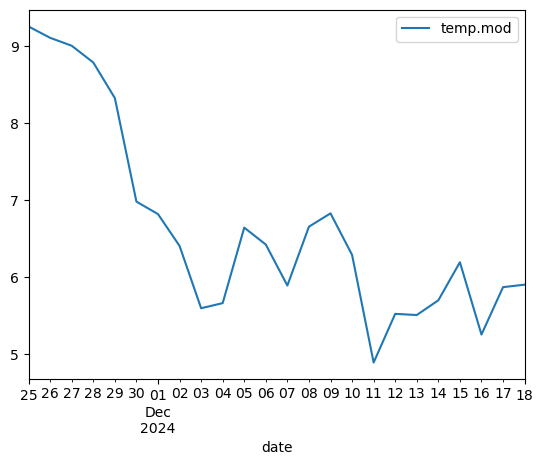

In [10]:
# Plot the forecast
forecast.plot(x="date", y="temp.mod", layout="compressed")

## Validation

To validate a forecast, specify the date it was run on.  The notebook will retrieve river temperature observations and evaluate performance.  In the line below, forecasts may be stored in "site_cache" or `basepath`.

The Dec. 1 run for the Potomac River had an RMSE of 2.2 C, right on target for average errors (biased by +2 C).  At Sagehen, the Dec 1 run was biased up by about 4.5 C (due to seasonality error; the trend was correct-ish). However, the Nov. 21-22 runs were much more accurate (RMSE of 2.8 and 3.0 C), since a large negative anomaly pulled it closer to true.

In [27]:
dates_run = [f.split("_")[-1] for f in os.listdir(basepath) if site in f and f.startswith("forecast")]
dates_run

['2024-12-01.csv']

In [29]:
dayrun = "2024-12-01"
file = basepath + f"forecast_{site}_{dayrun}.csv"
forecast = pd.read_csv(file, parse_dates=["date"])
first_day = dayrun  # don't go back before day-of, because it was still spinning up
last_day = forecast["date"].max().strftime("%Y-%m-%d")
# colname = "00010_Mean"  # usually
colname = "00010_from multiparameter sonde_Mean"  # because WHY USGS?  This is for the Potomac.
obs = nwis.get_dv(sites=[site], start=first_day, end=last_day, parameterCd="00010")[0][colname].reset_index().rename(columns={"datetime": "date", colname: "temperature"})
obs["date"] = obs["date"].dt.tz_localize(None)
data = forecast.merge(obs, how="inner", on="date")
data

,id,lat,lon,date,actemp,anom,temp.mod,temperature
0,1646500,38.949778,-77.127639,2024-12-01,8.228206,-1.411112,6.817094,5.9
1,1646500,38.949778,-77.127639,2024-12-02,8.068456,-1.663742,6.404714,4.8
2,1646500,38.949778,-77.127639,2024-12-03,7.910638,-2.314263,5.596376,3.9
3,1646500,38.949778,-77.127639,2024-12-04,7.754800,-2.092000,5.662801,3.3
4,1646500,38.949778,-77.127639,2024-12-05,7.600988,-0.959341,6.641647,3.1


In [30]:
np.sqrt(((data["temp.mod"] - data["temperature"])**2).mean())

2.209975162487629

<Axes: xlabel='date'>

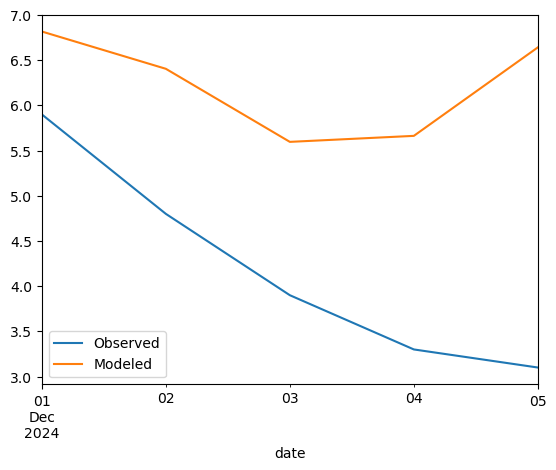

In [31]:
ax = data.plot(x="date", y="temperature", label="Observed")
data.plot(x="date", y="temp.mod", label="Modeled", ax=ax)

# Tightly Nested Watersheds

One approach to high-resolution modeling is to simply run a full, lumped watershed for each kilometer of river.  This is rather inefficient, since it involves a lot of redundant data retrieval, but it is straightforward because it can be run with only a lumped model.  It also serves to test the stability of model predictions in space.  The bulk of the analysis here is creating subwatersheds; after that, we simply run lumped models as per usual.

Since this isn't a good standard approach to high-resolution modeling, the watershed splicing is not built in to NEXT.

Kilometer spacing is not exact, since NHD+ spacing varies, but it is guaranteed to be less than 0.015 degrees, which is about 1.5 km in latitude and less (latitude-dependent) in longitude.

An alternative approach is to just interpolate along each linestring, instead of recursing.

## Set Up Coordinates

In [2]:
(ws, lat, lon, area) = NEXT.data.gage_geom(site)
coords = (lon, lat)
# resolution = 0.01  # 0.01 degrees is ~1.1 km latitude, ~0.9 km longitude
resolution = 0.01

In [3]:
def expand_line(line):
    count = line.length / resolution
    if count < 0.5:
        steps = []   # we don't want super-dense points on very short reaches
    elif count < 1.5:
        steps = [line.length]  # just the bottom
    else:
        steps = np.arange(resolution, line.length, resolution)
    return gpd.GeoSeries(line.interpolate(steps))

def expand_lines(geometry):
    return pd.concat([expand_line(g) for g in geometry])

<Axes: >

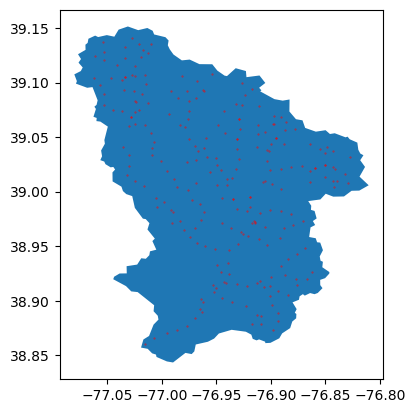

In [4]:
lines = nldi.navigate_byloc(coords, "upstreamTributaries", source="flowlines", distance=1000)
points = expand_lines(lines.geometry)
ax = ws.plot()
points.plot(ax=ax, c="red", markersize=0.1)

In [5]:
clist = [pt.coords[0] for pt in points]
print(len(clist))
clist[:5]

247


[(-77.00715167244856, 38.86599994706654),
 (-77.01503713038744, 38.86016550191219),
 (-76.97714217201427, 38.877012286542374),
 (-76.98648207671934, 38.87351581038549),
 (-76.99555285363746, 38.87020893756786)]

## Prepare Forecasts

To do this in many HPC runs, do the following.  Statics files start appearing after about 1 minute.  I recommend running GFS retrieval first, to make sure it goes through properly - things can get a bit weird when several jobs try to do it at once.  A full day's GFS NetCDF should be a little over 500 MB if it ran correctly. (Note this only needs to be run once per day - across all watersheds - since it retrieves data globally.)

If a previous retrieval ran incorrectly, it is necessary to delete the NetCDF.

In [3]:
print(f"python scripts/area_forecast.py {site} {basepath} [index] [Npartitions] 0.01 1000")

python scripts/area_forecast.py 01646500 /scratch/dphilippus/notebooks/forecast/ [index] [Npartitions] 0.01 1000


In [2]:
# help(NEXT.wforecast.get_gfs_downloaded)
NEXT.wforecast.get_gfs_downloaded(ws, "20241129", gribs)  # 6 days ago, too
NEXT.wforecast.get_gfs_downloaded(ws, "today", gribs)

Ignoring index file '/scratch/dphilippus/gfs/GFS_0p25_20241205_06_h0.grib.5b7b6.idx' older than GRIB file


date
2024-12-05     5.141021
2024-12-06    -0.214839
2024-12-07     4.242715
2024-12-08    13.285376
2024-12-09    12.693211
2024-12-10    12.311991
2024-12-11    12.849187
2024-12-12     7.443903
2024-12-13     5.212717
2024-12-14     7.071564
2024-12-15     7.300834
2024-12-16    11.319710
2024-12-17     9.943914
2024-12-18    10.350122
2024-12-19    12.991888
2024-12-20    14.317741
2024-12-21     8.868748
Name: tmax, dtype: float64

While we're at it, let's see how long this takes.

- Sagehen (19 points):
    - With full data retrieval: Approx. 1 hour, 3 min/ws.
    - With forecast retrieval only: ~instantaneous (2 seconds)
    - Without (modeling only): ~instantaneous
- Potomac (19,000 points, total area 27,000 km2) (10-km: 600 points)
    - With full data retrieval: 20-30 seconds per watershed.  If that's sustained, we can expect approx. 160 core-hours for a 1-km forecast.
    - With forecast retrieval only: ~2 seconds per watershed
    - Modeling only: 

In [2]:
def wrapper(op, start, crash=False, retry=True):
    try:
        result = op()
        delta = (time() - start) / 60
        print(f"\r{delta:08.2f}", end="")
        return result
    except Exception as e:
        if crash:
            raise e
        if retry:  # retry once
            return wrapper(op, start, crash, False)
        return None
fcst_run = run_forecasts(site, "coefs.pickle", basepath, gribs, 0.1, 1000)
start = time()
forecast_list = [
    wrapper(
        op,
        start,
        crash=True
    )
    for op in fcst_run
]
forecast = pd.concat(forecast_list)
runtime = (time() - start) / 3600
print(f"\rTook {runtime:.2f} hours")

00006.93


KeyboardInterrupt



## Load Existing Forecasts

They all go in the same place, so it's necessary to filter for the correct location.  For example, the Potomac sites are east of -80 longitude, while the Sagehen sites are well to the west.

Tracking:

Note that large numbers of jobs, e.g. 20, don't work well.  Daymet bandwidth?  Also, runs that keep going through midnight tend to generate prepared data but not actual forecasts, since the forecast retrieval can have issues.  Generating forecasts alone with prepared data is about 2,000 sites per job per hour (30-40/minute).  Pulling setup data brings it down to about 1 s/j/m.  Thus, full setup for the Potomac watershed is about 300-400 core-hours, while subsequent daily forecast runs are about 10 core-hours.  So setup is a fairly substantial task, but after that, forecast jobs can be readily run on a desktop workstation (e.g.: schedule a task to retrieve GFS data, then run forecasts on two threads, at 3 am, finishing around 8 am).

In [ ]:
fcst_files = [basepath + f for f in os.listdir(basepath) if f.startswith("forecast_-7") and "2024-12-05" in f]
forecast = pd.concat([pd.read_csv(f, parse_dates=["date"]) for f in fcst_files])
forecast.to_csv(basepath + "full_potomac_forecast_2024-12-05.csv", index=False)
forecast

In [4]:
forecast = pd.read_csv(basepath + "full_potomac_forecast_2024-12-05.csv", parse_dates=["date"])
forecast

,id,lat,lon,date,actemp,anom,temp.mod
0,-79.14076218119901:39.162202966781884,39.162203,-79.140762,2024-11-29,6.825213,-0.093879,6.731334
1,-79.14076218119901:39.162202966781884,39.162203,-79.140762,2024-11-30,6.677256,-0.243312,6.433944
2,-79.14076218119901:39.162202966781884,39.162203,-79.140762,2024-12-01,6.530963,-0.437881,6.093082
3,-79.14076218119901:39.162202966781884,39.162203,-79.140762,2024-12-02,6.386376,-0.934583,5.451793
4,-79.14076218119901:39.162202966781884,39.162203,-79.140762,2024-12-03,6.243537,-1.854934,4.388604
...,...,...,...,...,...,...,...
440323,-79.02633376249057:39.64573967427066,39.645740,-79.026334,2024-12-18,3.191837,1.428881,4.620718
440324,-79.02633376249057:39.64573967427066,39.645740,-79.026334,2024-12-19,3.090869,1.627992,4.718860
440325,-79.02633376249057:39.64573967427066,39.645740,-79.026334,2024-12-20,2.992103,1.879242,4.871345
440326,-79.02633376249057:39.64573967427066,39.645740,-79.026334,2024-12-21,2.895569,2.050538,4.946107


In [5]:
len(forecast["id"].unique())

18347

## Plot Forecasts

Trends tend to be fairly similar (though varying in magnitude) within an area, since the region is affected by similar weather fronts.

We can also plot a single day, or animate it.

The timeseries plot gets unreasonably slow at several tens of thousands of rows, so I recommend against running it for large watersheds.

In [ ]:
ax = sns.scatterplot(forecast, x="date", y="temp.mod")
ax.legend().remove()
ax.set_xlabel("Date")
ax.set_ylabel("Forecast Mean Daily Temperature (C)")
ax.set_title("Potomac Watershed Points")
ax.tick_params(axis='x', rotation=45)

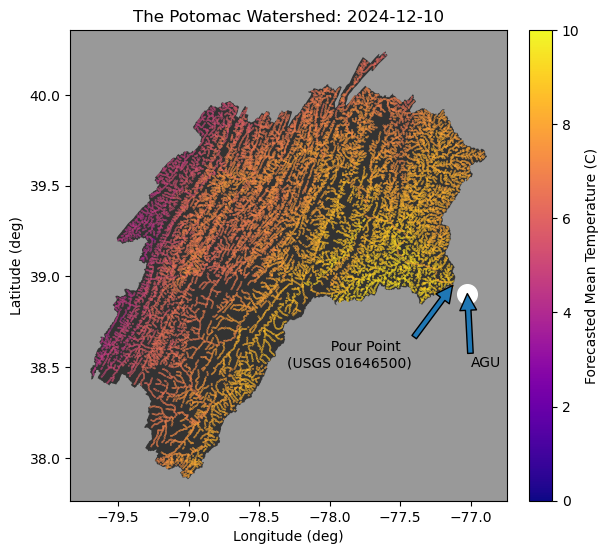

In [6]:
fig = plt.figure(figsize=(6, 6), layout="compressed")
ax = plt.axes(facecolor="#999")
dat = forecast[forecast["date"] == "2024-12-10"]
ws.plot(ax=ax, color="#333")
dat.plot.scatter(x="lon", y="lat", c="temp.mod", s=0.1, title="The Potomac Watershed: 2024-12-10", ax=ax, colormap="plasma", vmin=0, vmax=int(dat["temp.mod"].max()) + 1)
# DC convention center
dcx = -77.02299677632044
dcy = 38.90490577636493
ax.scatter(x=dcx, y=dcy, s=200, c="white")
ax.annotate("AGU", (dcx, dcy), xytext=(-77, 38.5), arrowprops={})
ax.annotate(f"          Pour Point\n(USGS {site})", (lon, lat),
            xytext=(-78.3, 38.5), arrowprops={})
ax.collections[1].colorbar.set_label("Forecasted Mean Temperature (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("figures/Potomac_20241210.png", dpi=300)

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(facecolor="#999")
dates = np.array(forecast["date"].unique(), dtype='datetime64[D]')
# We don't want to run the spinup time, since the anomaly is inaccurate
dates = dates[dates >= np.datetime64("2024-12-01")]
dates.sort()
def animate(i):
    date = dates[i]
    fig.clear()
    ax = plt.axes(facecolor="#999")
    ws.plot(ax=ax, color="#333")
    forecast[forecast["date"] == date].plot.scatter(x="lon", y="lat", c="temp.mod", title=str(date), ax=ax, colormap="plasma", vmin=0, vmax=int(forecast["temp.mod"].max()) + 1, s=0.1)
    ax.collections[1].colorbar.set_label("Forecasted Mean Temperature (C)")
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")
    plt.tight_layout()

a = anim.FuncAnimation(fig, animate, interval=500, frames=range(len(dates)))
a.save(f"forecast_anims/{site}_forecast.gif")